In [2]:
import findspark
findspark.init()

In [160]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, PCA, VectorSlicer, RobustScaler, StandardScaler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType

import pandas as pd

from matplotlib import pyplot as plt

### Загрузим данные

In [204]:
spark = SparkSession.builder.appName("credit_cards").master('local[*]').getOrCreate()

In [205]:
data = spark.read.csv('creditcard.csv', header=True, inferSchema=True)

In [6]:
data.show(n=7)

+----+------------------+-------------------+------------------+------------------+-------------------+-------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                V4|                 V5|                 V6|                  V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|                V17|                V18|                V19|                V20|                 V21|              

### 1. Сначала построим бинарную классификацию, основанную на всех признаках

In [206]:
# Добавим столбец, в котором будет частота каждого класса, вычтенная из единицы
window = Window.partitionBy('Class')
data = data.withColumn('weights', 1 - F.count('Class').over(window) / data.count())
data.show(n=5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+--------------------+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                 V21|    

In [8]:
# Используемые фичи для классификации
features = data.columns[:-2]

In [9]:
# Векторизуем признаки
vector_assembler = VectorAssembler(inputCols=features, outputCol='features')
data_with_features = vector_assembler.transform(data)

In [10]:
# Поделим на обучающую и тестовую выборки
train, test = data_with_features.randomSplit([0.8, 0.2], seed=123)

In [11]:
# Инициализируем и обучим случайный лес
rf = RandomForestClassifier(featuresCol='features', labelCol='Class', predictionCol='predictions', weightCol='weights', seed=123).fit(train)

In [12]:
# Сделаем предсказания на тестовой выборке
predictions = rf.transform(test)

In [13]:
# Confusion matrix
predictions.groupBy('predictions', 'Class').count().show()

+-----------+-----+-----+
|predictions|Class|count|
+-----------+-----+-----+
|        0.0|    0|56647|
|        1.0|    0|  240|
|        0.0|    1|   17|
|        1.0|    1|   76|
+-----------+-----+-----+


In [14]:
print(BinaryClassificationEvaluator(labelCol='Class', rawPredictionCol='predictions', metricName='areaUnderROC').evaluate(predictions))

0.9064927054974672


In [15]:
# Feature importance
pd.Series(rf.featureImportances.toArray(), index=features)

Time      0.000530
V1        0.003853
V2        0.002976
V3        0.011482
V4        0.098154
V5        0.001636
V6        0.005632
V7        0.031611
V8        0.001969
V9        0.052898
V10       0.181439
V11       0.010659
V12       0.095061
V13       0.003460
V14       0.309033
V15       0.001424
V16       0.059222
V17       0.093683
V18       0.000947
V19       0.005072
V20       0.006865
V21       0.006030
V22       0.003820
V23       0.002034
V24       0.001716
V25       0.000441
V26       0.001649
V27       0.000851
V28       0.001742
Amount    0.004110
dtype: float64

### 2. Далее кластеризуем данные по V-признакам

In [16]:
features_for_cluster = data.columns[1:-2]

In [17]:
assembler_for_cluster = VectorAssembler(inputCols=features_for_cluster, outputCol='features')
data_for_cluster = assembler_for_cluster.transform(data)

### Здесь нам ничего не остается, кроме как подобрать количество кластеров через коэффициент силуэта

In [18]:
silhouette_score = []

cluster_evaluator = ClusteringEvaluator(predictionCol='cluster', metricName='silhouette', featuresCol='features',
                                        distanceMeasure='squaredEuclidean')

In [19]:
for i in range(2, 25):
    kmeans_model = KMeans(featuresCol='features', initMode='k-means||', k=i, predictionCol='cluster').fit(data_for_cluster)
    predictions = kmeans_model.transform(data_for_cluster)
    score = cluster_evaluator.evaluate(predictions)
    silhouette_score.append(score)


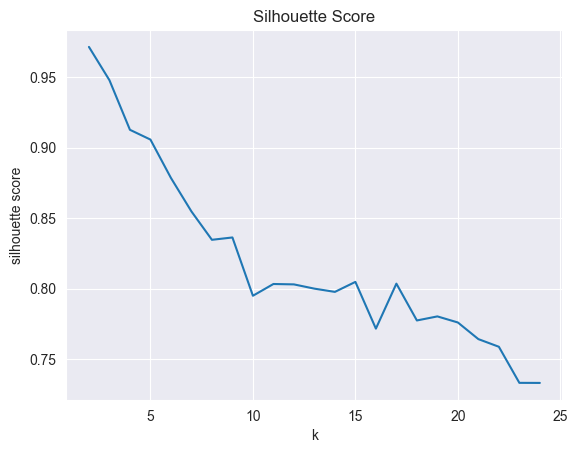

In [20]:
plt.plot(range(2, 25), silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [21]:
# Выберем k=12
kmeans_model = KMeans(featuresCol='features', initMode='k-means||', k=12, predictionCol='cluster').fit(data_for_cluster)

In [22]:
data_with_clusters = kmeans_model.transform(data_for_cluster)

C:\Users\User\AppData\Local\Temp\ipykernel_12604\2464377994.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


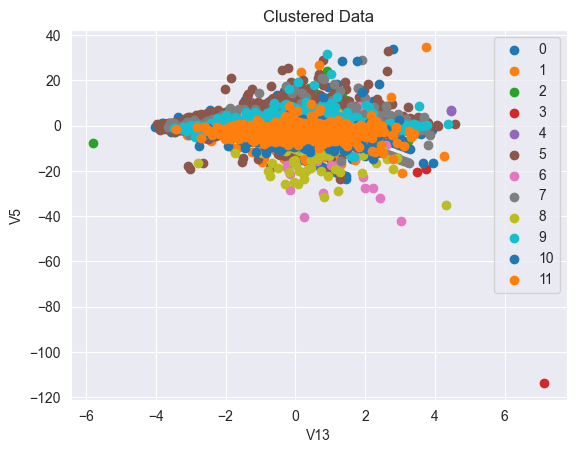

In [23]:
# Визуализируем кластеры в проекции на V5-V13
data_pd = data_with_clusters.toPandas()

fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(12):
    data_plot = data_pd[data_pd['cluster'] == i]
    ax.scatter(x=data_plot['V13'], y=data_plot['V5'], label=i)
ax.legend()
ax.set_title('Clustered Data')
ax.set_xlabel('V13')
ax.set_ylabel('V5')
fig.show()

### 3. Наконец, попробуем построить модель классификации с использованием кластеров

In [24]:
# Сначала сделаем One-Hot vectors из признака cluster
features_one_hot = data_with_clusters.columns[:-3] + data_with_clusters.columns[-1:] + data_with_clusters.columns[-3:-2]
data_second = data_with_clusters.select(features_one_hot)
one_hot_model = OneHotEncoder(inputCol='cluster', outputCol='one_hot_cluster', dropLast=False).fit(data_second)
one_hot_data = one_hot_model.transform(data_second)

In [25]:
one_hot_data.show(n=3)

+----+-----------------+-------------------+----------------+-----------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+-------------------+------+-----+-------+--------------------+---------------+
|Time|               V1|                 V2|              V3|               V4|                V5|                 V6|                 V7|                V8|                V9|               V10|               V11|               V12|               V13|               V14|              V15|               V16|               V17|               V18|               V19|                V20|               V

In [26]:
features_second = one_hot_data.columns[:-4] + one_hot_data.columns[-1:]
data_second = VectorAssembler(inputCols=features_second, outputCol='features').transform(one_hot_data)

In [27]:
train, test = data_second.randomSplit([0.8, 0.2], seed=123)

In [28]:
rf = RandomForestClassifier(featuresCol='features', labelCol='Class', predictionCol='predictions', weightCol='weights', seed=123).fit(train)

In [29]:
predictions = rf.transform(test)

In [30]:
predictions.groupBy('predictions', 'Class').count().show()

+-----------+-----+-----+
|predictions|Class|count|
+-----------+-----+-----+
|        0.0|    0|56722|
|        0.0|    1|   17|
|        1.0|    1|   76|
|        1.0|    0|  165|
+-----------+-----+-----+


In [31]:
print(BinaryClassificationEvaluator(labelCol='Class', rawPredictionCol='predictions', metricName='areaUnderROC').evaluate(predictions))

0.9071519070725194


### 4. PCA + Classification

In [207]:
train_for_pca, test_for_pca = data.randomSplit([0.8, 0.2], seed=123)

In [208]:
assembler_for_scaling = VectorAssembler(inputCols=['Time', 'Amount'], outputCol='time_and_amount')

scaler = RobustScaler(inputCol='time_and_amount', outputCol='scaled', withCentering=True)

pipeline_for_scaling = Pipeline(stages=[assembler_for_scaling, scaler]).fit(train_for_pca)

In [209]:
train_for_pca_with_scaling = pipeline_for_scaling.transform(train_for_pca)

In [210]:
assembler_for_scaling = VectorAssembler(inputCols=train_for_pca_with_scaling.columns[1:29] + train_for_pca_with_scaling.columns[-1:], outputCol='features')
std_scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=False, withMean=True)
pca = PCA(k=2, inputCol='scaledFeatures', outputCol='PCA_features')

pipeline_for_pca = Pipeline(stages=[assembler_for_scaling, std_scaler, pca]).fit(train_for_pca_with_scaling)

In [212]:
train_with_pca = pipeline_for_pca.transform(train_for_pca_with_scaling)

In [213]:
first_slicer = VectorSlicer(inputCol='PCA_features', outputCol='first_attr', indices=[0])
train_with_pca = first_slicer.transform(train_with_pca)

second_slicer = VectorSlicer(inputCol='PCA_features', outputCol='second_attr', indices=[1])
train_with_pca = second_slicer.transform(train_with_pca)

In [214]:
x = train_with_pca.select('first_attr').collect()
y = train_with_pca.select('second_attr').collect()

In [215]:
colors_map = {
  0: '#3b4cc0',
  1: '#f2da0a',
}

In [216]:
class_for_color = train_with_pca.select('Class').collect()

In [217]:
colors = list(map(lambda p: colors_map[p[0]], class_for_color))

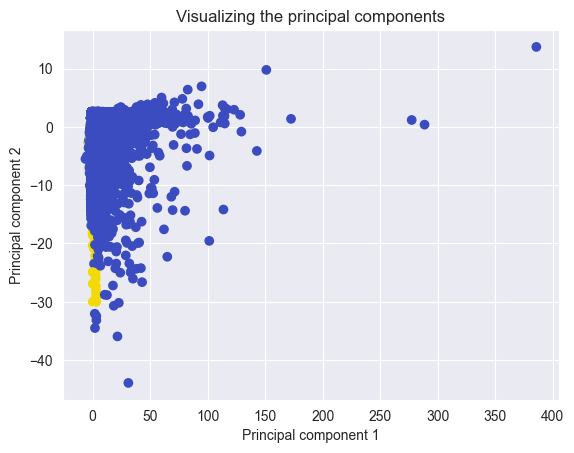

In [218]:
plt.scatter(x, y, c=colors)
plt.title(f'Visualizing the principal components')
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.show()

In [219]:
rf = RandomForestClassifier(featuresCol='PCA_features', labelCol='Class', predictionCol='predictions', weightCol='weights', seed=123).fit(train_with_pca)

In [220]:
# Обработка тестовой выборки
test_for_pca = pipeline_for_scaling.transform(test_for_pca)

test_with_pca = pipeline_for_pca.transform(test_for_pca)

In [222]:
predictions = rf.transform(test_with_pca)

In [223]:
predictions.groupBy('predictions', 'Class').count().show()

+-----------+-----+-----+
|predictions|Class|count|
+-----------+-----+-----+
|        1.0|    0| 6892|
|        0.0|    0|49995|
|        1.0|    1|   75|
|        0.0|    1|   18|
+-----------+-----+-----+


In [224]:
print(BinaryClassificationEvaluator(labelCol='Class', rawPredictionCol='predictions', metricName='areaUnderROC').evaluate(predictions))

0.8426495763814738
